# Wrangle and Analyze Data of a Twitter Account


## Table of Contents
- [0. Introduction](#intro)
- [1. Gather data](#gather)
- [2. Assess data](#assess)
- [3. Clean data](#clean)
- [4. Analysis & Visualization](#analysis)


<a id='gather'></a>
## 0. Introduction

This project is an analysis of the WeRateDog account. Main goal of this project is to follow through the complete Data Analysis process. Firstly data is gathered from different sources: a local csv-file, a programmatically downloaded file and data downloaded via the twitter API. Secondly the data from the different sources is visually and programmatically assessed to be cleaned in the next step for the final analysis. The analysis compares the ratings, retweets and favorites of different dog stages and races.

In [848]:
# Import necessary libraries
import numpy as np
import pandas as pd
import requests # to download files programmatically 
import os # to work with local directory
import tweepy # for twitter-api
import time # for timer 
import json # to create json file from python dictionary
import re

<a id='intro'></a>
## 1. Gather data

####  Data is gathered from three different sources of data as described in steps below:

1. The WeRateDogs Twitter archive. File `twitter_archive_enhanced.csv` as comma separated file in local directory.
2. The tweet image predictions, i.e., what breed of dog (or other object, animal, etc.) is present in each tweet according to a neural network. This file (image_predictions.tsv) is hosted on Udacity's servers at [URL](https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv).
3. Each tweet's retweet count and favorite ("like") count. Using the tweet IDs in the WeRateDogs Twitter archive,  the Twitter API is queried for each tweet's JSON data using Python's Tweepy library and each tweet's entire set of JSON data is stored in a file called tweet_json.txt file. Each tweet's JSON data is written to its own line. Then this .txt file is read line by line into a pandas DataFrame with tweet ID, retweet count, and favorite count.

### a. Read data from csv-file

In [490]:
# Read WeRateDogs Twitter archive from csv
df_twitter_archive_enhanced = pd.read_csv('twitter-archive-enhanced.csv')

### b. Programmatically download file from url

In [491]:
# Create request-object with url of file
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
response = requests.get(url)

In [492]:
# Create file with content of response-object
with open(url.split('/')[-1], mode='wb') as file: 
    file.write(response.content)

In [493]:
# Read tweet image predictions from tsv
df_image_predictions = pd.read_csv(url.split('/')[-1], sep='\t')

### c. Query additional information for tweets via Twitter API

In [494]:
# Define credentials for twitter api
try:
    with open("pw.json", "r") as read_file:
        pw = json.load(read_file)

# Catch exception, if file doesn't exist
except FileNotFoundError as fnf_error:
    print(fnf_error)
    print('File pw.json with twitter credentials missing')
    
consumer_key = pw['consumer_key']
consumer_secret = pw['consumer_secret']
access_token = pw['access_token']
access_secret = pw['access_secret']

In [495]:
# Initiate session with Twitter API
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)
api = tweepy.API(auth)

In [496]:
# Query for every tweet id in enhanced twitter archive and save tweet-information in json-format to 'tweet_json.txt'
tweet_jsons = {}
tweet_id_errors = []
start = time.time()
count = 0


with open('tweet_json.txt', 'w') as outfile:
    
    for tweet_id in df_twitter_archive_enhanced['tweet_id']:
        count +=1
        try:
            # Query API for data of tweet id, setting tweet_mode parameter to 'extended'
            tweet = api.get_status(tweet_id, tweet_mode='extended', wait_on_rate_limit=True, wait_on_rate_limit_notify=True)
            # Measure elapsed time
            mid_s = time.time()
            # Print id and time elapsed
            ## print(str(count) + ": " + str(tweet_id) + " was successfully queried at " + str(mid_s - start) )
            # Write json of tweet to 'tweet_json.txt'
            json.dump(tweet._json, outfile)
            # New line
            outfile.write("\n")

        # Not best practice to catch all exceptions but fine for this short script
        except Exception as error:
            mid_f = time.time()
            ## print(str(count) + ": " + str(tweet_id) + " could not be queried " + str(mid_f - start) + str(error))
            # Gather ids of id's without status
            tweet_id_errors.append([count, str(tweet_id)])
            
    end = time.time()
    print(end - start)
df_tweet_id_errors = pd.DataFrame(tweet_id_errors, columns=['tweet_index', 'tweet_id'])

Rate limit reached. Sleeping for: 690
Rate limit reached. Sleeping for: 710


1928.3107409477234


In [497]:
# Create empty list
tweet_api_info = []

# Open file with handle as best practice and for every json-object append interesting info to tweet_api_info
try:
    with open('tweet_json.txt') as file:
        
        for jsonObj in file:
            tweet = json.loads(jsonObj)
            tweet_api_info.append([tweet['id'], tweet['retweet_count'], tweet['favorite_count']])

# Catch exception, if file doesn't exist
except FileNotFoundError as fnf_error:
    print(fnf_error)

# Convert list to pandas dataframe
df_tweet_api_info = pd.DataFrame(tweet_api_info, columns=['tweet_id', 'retweet_count', 'favorite_count'])

In [498]:
# For development purposes store api-info to csv
df_tweet_api_info.to_csv('df_tweet_api_info.csv', encoding='utf-8')

<a id='assess'></a>
## 2. Assess data

After gathering each of the above pieces of data, they are assessed visually and programmatically for quality and tidiness issues. Requirements to be met:

- Quality requirements:
    - Completeness: All necessary records in dataframes, no specific rows, columns or cells missing.
    - Validity: No records available, that do not conform schema.
    - Accuracy: No wrong data, that is valid.
    - Consistency: No data, that is valid and accurate, but referred to in multiple correct ways.
- Tidiniss requirements (as defined by Hadley Wickham):
    - each variable is a column
    - each observation is a row
    - each type of observational unit is a table.

### a. Visual assessment

In [499]:
# Assess df_twitter_archive_enhanced visually
df_twitter_archive_enhanced.sample(n=5)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
317,834786237630337024,NaN,NaN,2017-02-23 15:25:23 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tobi. She is properly fetching her sho...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/834786237...,13,10,Tobi,None,None,None,None
373,828376505180889089,NaN,NaN,2017-02-05 22:55:23 +0000,"<a href=""http://twitter.com/download/iphone"" r...","This is Beebop. Her name means ""Good Dog"" in r...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/828376505...,13,10,Beebop,None,None,None,None
1671,682393905736888321,NaN,NaN,2015-12-31 02:52:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Kreg. He's riding an invisible jet ski...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/682393905...,11,10,Kreg,None,None,None,None
2054,671390180817915904,NaN,NaN,2015-11-30 18:07:47 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Striped dog here. Having fun playing on back. ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/671390180...,7,10,None,None,None,None,None
354,831262627380748289,NaN,NaN,2017-02-13 22:03:49 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tucker. He's feeling h*ckin festive an...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/831262627...,12,10,Tucker,None,None,None,None


In [500]:
# Assess df_image_predictions visually
df_image_predictions.sample(n=10)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
338,672239279297454080,https://pbs.twimg.com/media/CVRGDrsWsAAUWSF.jpg,1,pug,0.332536,True,French_bulldog,0.258124,True,bull_mastiff,0.120873,True
717,685663452032069632,https://pbs.twimg.com/ext_tw_video_thumb/68566...,1,Chesapeake_Bay_retriever,0.171174,True,tennis_ball,0.090644,False,racket,0.048508,False
1416,771136648247640064,https://pbs.twimg.com/media/CrOgsIBWYAA8Dtb.jpg,1,bathtub,0.368660,False,golden_retriever,0.297402,True,tub,0.201711,False
1819,834209720923721728,https://pbs.twimg.com/media/C5O1UAaWIAAMBMd.jpg,1,golden_retriever,0.754799,True,Pekinese,0.197861,True,Labrador_retriever,0.008654,True
1661,811744202451197953,https://pbs.twimg.com/media/C0PlCQjXAAA9TIh.jpg,1,Pekinese,0.386082,True,Labrador_retriever,0.202862,True,golden_retriever,0.170487,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
770,689289219123089408,https://pbs.twimg.com/ext_tw_video_thumb/68928...,1,snowmobile,0.254642,False,assault_rifle,0.129558,False,rifle,0.110875,False
882,698710712454139905,https://pbs.twimg.com/media/CbJRrigW0AIcJ2N.jpg,1,Samoyed,0.329895,True,shoji,0.165772,False,prison,0.103596,False
2070,891327558926688256,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True
190,669393256313184256,https://pbs.twimg.com/media/CUopnHPVEAAcL2o.jpg,1,cocker_spaniel,0.359843,True,Blenheim_spaniel,0.139519,True,toy_poodle,0.132746,True


In [501]:
df_image_predictions.query('tweet_id == 749317047558017024')['jpg_url']

1265    https://pbs.twimg.com/ext_tw_video_thumb/74931...
Name: jpg_url, dtype: object

In [502]:
# Assess df_tweet_api_info visually
df_tweet_api_info.sample(n=10)

,tweet_id,retweet_count,favorite_count
1546,687732144991551489,667,1765
484,813112105746448384,2808,10546
2028,671485057807351808,227,735
614,793962221541933056,5030,17263
1425,696100768806522880,654,1938
2035,671182547775299584,324,1084
284,837110210464448512,2370,16133
1939,673350198937153538,203,728
1724,679047485189439488,661,2238
1893,674271431610523648,710,1529


### b. Programmatic assessment

In [503]:
# Check datatypes and non-null count of columns in df_twitter_archive_enhanced
df_twitter_archive_enhanced.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

In [504]:
# Check if column rating_denominator of df_twitter_archive_enhanced only consists of value 10
df_twitter_archive_enhanced.rating_denominator.value_counts()

10     2333
11        3
50        3
80        2
20        2
2         1
16        1
40        1
70        1
15        1
90        1
110       1
120       1
130       1
150       1
170       1
7         1
0         1
Name: rating_denominator, dtype: int64

In [505]:
# Check column rating_numerator for realistic values
df_twitter_archive_enhanced.rating_numerator.value_counts() 

12      558
11      464
10      461
13      351
9       158
8       102
7        55
14       54
5        37
6        32
3        19
4        17
1         9
2         9
420       2
0         2
15        2
75        2
80        1
20        1
24        1
26        1
44        1
50        1
60        1
165       1
84        1
88        1
144       1
182       1
143       1
666       1
960       1
1776      1
17        1
27        1
45        1
99        1
121       1
204       1
Name: rating_numerator, dtype: int64

In [506]:
# Check for most common values in column name of df_twitter_archive_enhanced
df_twitter_archive_enhanced.name.value_counts() 

None         745
a             55
Charlie       12
Cooper        11
Oliver        11
            ... 
Alejandro      1
Tessa          1
Arlo           1
Ron            1
Cupid          1
Name: name, Length: 957, dtype: int64

In [645]:
# Inspect texts of some tweets without dog name 
df_twitter_archive_enhanced.query('name == "None"').sample(n=5)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
2184,668988183816871936,NaN,NaN,2015-11-24 03:03:06 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Honor to rate this dog. Lots of fur on him. Tw...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/668988183...,7,10,None,None,None,None,None
798,772877495989305348,NaN,NaN,2016-09-05 19:22:09 +0000,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",You need to watch these two doggos argue throu...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/772877495...,11,10,None,None,None,None,None
2343,666073100786774016,NaN,NaN,2015-11-16 01:59:36 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Let's hope this flight isn't Malaysian (lol). ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666073100...,10,10,None,None,None,None,None
1714,680440374763077632,NaN,NaN,2015-12-25 17:30:01 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Merry Christmas. My gift to you is this tiny u...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/680440374...,11,10,None,None,None,None,None
788,774314403806253056,NaN,NaN,2016-09-09 18:31:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",I WAS SENT THE ACTUAL DOG IN THE PROFILE PIC B...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/774314403...,14,10,None,None,None,None,None


In [646]:
# Inspect texts of some tweets with value "a" in column "name"
df_twitter_archive_enhanced.query('name == "a"').sample(n=5)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
1737,679530280114372609,NaN,NaN,2015-12-23 05:13:38 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Guys this really needs to stop. We've been ove...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/679530280...,7,10,a,None,None,None,None
1785,677644091929329666,NaN,NaN,2015-12-18 00:18:36 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a dog swinging. I really enjoyed it so...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/677644091...,11,10,a,None,None,None,None
2161,669564461267722241,NaN,NaN,2015-11-25 17:13:02 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a Coriander Baton Rouge named Alfredo....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/669564461...,10,10,a,None,None,None,None
2352,666044226329800704,NaN,NaN,2015-11-16 00:04:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a purebred Piers Morgan. Loves to Netf...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666044226...,6,10,a,None,None,None,None
2287,667177989038297088,NaN,NaN,2015-11-19 03:10:02 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a Dasani Kingfisher from Maine. His na...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/667177989...,8,10,a,None,None,None,None


In [507]:
# Check datatypes and non-null count of columns in df_image_predictions
df_image_predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [508]:
# Check for percentiles and standard deviation of image prediction confidence
df_image_predictions.describe()

,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


In [509]:
# Check if p1_conf means highest condifdence level
np.mean(df_image_predictions.p1_conf > df_image_predictions.p2_conf)

1.0

In [510]:
# Check datatypes and non-null count of columns in df_tweet_api_info
df_tweet_api_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2331 entries, 0 to 2330
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   tweet_id        2331 non-null   int64
 1   retweet_count   2331 non-null   int64
 2   favorite_count  2331 non-null   int64
dtypes: int64(3)
memory usage: 54.8 KB


In [511]:
df_tweet_id_errors

,tweet_index,tweet_id
0,20,888202515573088257
1,96,873697596434513921
2,102,872668790621863937
3,105,872261713294495745
4,119,869988702071779329
5,133,866816280283807744
6,156,861769973181624320
7,183,856602993587888130
8,212,851953902622658560
9,248,845459076796616705


In [512]:
# Check for duplicate column names across three dataframes
all_columns = pd.Series(list(df_twitter_archive_enhanced) + list(df_image_predictions) + list(df_tweet_api_info))
all_columns[all_columns.duplicated()]

17    tweet_id
29    tweet_id
dtype: object

In [513]:
# Statistical description of dataframe, min-values, max-values, quartiles
df_tweet_api_info.describe()

,tweet_id,retweet_count,favorite_count
count,2.331000e+03,2331.000000,2331.00000
mean,7.419079e+17,2716.009438,7595.36894
std,6.823170e+16,4594.501971,11786.22056
min,6.660209e+17,1.000000,0.00000
25%,6.782670e+17,548.000000,1327.00000
50%,7.182469e+17,1275.000000,3306.00000
75%,7.986692e+17,3154.000000,9302.00000
max,8.924206e+17,78211.000000,156978.00000


### Findings, which contradict requirements:

##### `df_twitter_archive_enhanced` table

- Validity: Not all tweets are dog ratings, some are retweets. 181 Retweets, identied by values in columns `retweeted_status_id`, `retweeted_status_user_id` and `retweeted_status_timestamp`.
- Validity: Not all tweets are dog ratings, some are retweets. Retweets: 78 non-null values in columns `in_reply_to_status_id` and `in_reply_to_user_id`.
- Validity: Not all values in column `rating_denominator`are equal to 10.
- Completeness: Not all rows have a value in either one of the following columns: `doggo`, `floofer`, `pupper`, `puppo`.
- Consistency: Duplicate info in column `text` to columns `rating_numerator`, `rating_denominator`, `name`, `doggo`, `floofer`, `pupper`, `puppo`. 
- Completeness: There are 745 entries 'None' and 55 entries 'a' in the column `name`. 
- Accuracy: Column `timestamp` is not of type datetime.
- Validity: In column `expanded_urls` the urls match mainly `https://twitter.com/dog_rates/status/`, yet there is one example where the url starts with `https://gofundme.com/ydvmve-surgery-for-`.


##### `df_image_predictions` table
- Consistency: Up to three different images with three possible interpretations what is depicted on the image. Ratings of interest always refer to one dog. Not all images depict dogs (regarding the image recognition/prediction table).

#### `df_tweet_api_info`table
- Accuracy: Columns `retweet_count` and `favorite_count` are of type float, where they can only be integers as values.

#### Tidiness Observations:
- Variable `text`contains multiple observational units `rating_numerator`, `rating_denominator`, `name`, `doggo`, `floofer`, `pupper`, `puppo`.
- One variable (dog stage) in four columns in `treatments` table (doggo, floofer, pupper and puppo) of type categorical. 
- One observational unit in in three tables, `df_twitter_archive_enhanced`, `df_image_predictions`and `df_tweet_api_info`, different amount of rows.

<a id='clean'></a>
## 3. Clean data

In [1683]:
# Create copies for cleaning process to preserve original dataframes
df_twitter_archive_enhanced_clean = df_twitter_archive_enhanced.copy()
df_image_predictions_clean = df_image_predictions.copy()
df_tweet_api_info_clean = df_tweet_api_info.copy()

### Issue 1:
#### Observe:
- Validity: Not all tweets are dog ratings, some are retweets. 181 Retweets, identied by values in columns `retweeted_status_id`, `retweeted_status_user_id` and `retweeted_status_timestamp`.

#### Define:
- Drop rows, which can be identified as retweets by non-null values in columns `retweeted_status_id`, `retweeted_status_user_id` and `retweeted_status_timestamp`. Furthermore drop columns `retweeted_status_id`, `retweeted_status_user_id` and `retweeted_status_timestamp`, as not necessary anymore.

#### Code:

In [1684]:
# Keep only rows without values in 'retweeted_status_id'
df_twitter_archive_enhanced_clean = df_twitter_archive_enhanced_clean[
    df_twitter_archive_enhanced_clean['retweeted_status_id'].isnull()]

# Drop variables which are only necessary for retweets
df_twitter_archive_enhanced_clean.drop(['retweeted_status_id', 'retweeted_status_user_id', 
                                        'retweeted_status_timestamp'], axis=1, inplace=True)

#### Test:

In [1685]:
# Check if amount twitter ids reduced as expected
assert len(df_twitter_archive_enhanced_clean) == len(df_twitter_archive_enhanced)-181

In [1686]:
# Check if columnns `in_reply_to_status_id`, `in_reply_to_user_id` and `retweeted_status_timestamp` dropped
list(df_twitter_archive_enhanced)

['tweet_id',
 'in_reply_to_status_id',
 'in_reply_to_user_id',
 'timestamp',
 'source',
 'text',
 'retweeted_status_id',
 'retweeted_status_user_id',
 'retweeted_status_timestamp',
 'expanded_urls',
 'rating_numerator',
 'rating_denominator',
 'name',
 'doggo',
 'floofer',
 'pupper',
 'puppo']

### Issue 2:
#### Observe:
- Validity: Not all tweets are dog ratings, some are replies. 78 replies, identied by values in columns `in_reply_to_status_id` and `in_reply_to_user_id`.

#### Define:
- Drop rows, which can be identified as replies by non-null values in columns `in_reply_to_status_id` and `in_reply_to_user_id`. Furthermore drop columns `in_reply_to_status_id` and `in_reply_to_user_id`, as not necessary anymore.

#### Code:

In [1687]:
# Keep only rows without values in 'in_reply_to_status_id'
df_twitter_archive_enhanced_clean = df_twitter_archive_enhanced_clean[df_twitter_archive_enhanced_clean[
    'in_reply_to_status_id'].isnull()]

# Drop variables which are only necessary for replies
df_twitter_archive_enhanced_clean.drop(['in_reply_to_status_id', 'in_reply_to_user_id'], 
                                       axis=1, inplace=True)

#### Test:

In [1688]:
# Check if amount twitter ids reduced as expected
assert len(df_twitter_archive_enhanced_clean) == len(df_twitter_archive_enhanced)-181-78

In [1689]:
# Check if columnns `in_reply_to_status_id`, `in_reply_to_user_id` and `retweeted_status_timestamp` dropped
list(df_twitter_archive_enhanced_clean)

['tweet_id',
 'timestamp',
 'source',
 'text',
 'expanded_urls',
 'rating_numerator',
 'rating_denominator',
 'name',
 'doggo',
 'floofer',
 'pupper',
 'puppo']

In [1690]:
# Check if any row left without value in rating_numerator column
assert len(df_twitter_archive_enhanced_clean[df_twitter_archive_enhanced_clean['rating_numerator'].isnull()]) == 0

### Issue 3:
#### Observe:
- Validity: Not all values in column `rating_denominator`are equal to 10. Not all ratings seem to be valid.

#### Define
- Extract `rating_numerator`, `rating_denominator`variables from the text column using regular expressions and pandas' str.extract method. Drop the ratings column when done. Delete rows which do not have 10 as denominator.

#### Code:

In [1691]:
# Extract rating_numerator/rating_denominator via regex
df_twitter_archive_enhanced_clean['rating'] = df_twitter_archive_enhanced_clean.text.str.extract(
    '(\d{1,2}\.?\d{1,2}?\/10)', expand=True)

# Split the values in 'rating' column to columns 'rating_numerator' and 'rating_denominator'
df_twitter_archive_enhanced_clean['rating_numerator_text'], df_twitter_archive_enhanced_clean[
    'rating_denominator_text'] = df_twitter_archive_enhanced_clean['rating'].str.split('/', 1).str


/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  import sys


In [1692]:
# NaN is not comparable, therfore replace all NaN with 'None'
df_twitter_archive_enhanced_clean['rating_numerator_text'] = df_twitter_archive_enhanced_clean['rating_numerator_text'].replace(np.nan, 'None')

# Function to apply, which goes through 3 available guesses and picks the one with highest confidence beeing dog
def fill_missing_numerators(tweet):
    if tweet['rating_numerator_text'] == 'None':
        rating_numerator = tweet['rating_numerator']
        return rating_numerator
    else:
        rating_numerator = tweet['rating_numerator_text']
        return rating_numerator

# Apply function to dataframe    
df_twitter_archive_enhanced_clean['rating_numerator_merge'] = df_twitter_archive_enhanced_clean.apply(fill_missing_numerators, axis=1)


df_twitter_archive_enhanced_clean['rating_numerator'] = df_twitter_archive_enhanced_clean['rating_numerator_merge']

# Note: axis=1 denotes that referring to a column, not a row
df_twitter_archive_enhanced_clean.drop(['rating_numerator_merge', 'rating_numerator_text'], axis=1, inplace=True)


In [1693]:
# Drop rows which do not conform the (\d{1,2}\/10) format for ratings
df_twitter_archive_enhanced_clean = df_twitter_archive_enhanced_clean[df_twitter_archive_enhanced_clean.rating_numerator.notnull()]
df_twitter_archive_enhanced_clean = df_twitter_archive_enhanced_clean[df_twitter_archive_enhanced_clean.rating_denominator.notnull()]

# Convert columns to int
df_twitter_archive_enhanced_clean.rating_numerator = pd.to_numeric(df_twitter_archive_enhanced_clean.rating_numerator)
df_twitter_archive_enhanced_clean.rating_denominator = pd.to_numeric(df_twitter_archive_enhanced_clean.rating_denominator)

# Note: axis=1 denotes that referring to a column, not a row
df_twitter_archive_enhanced_clean.drop('rating', axis=1, inplace=True)

In [1694]:
# Drop rows with denominator other than 10
df_twitter_archive_enhanced_clean = df_twitter_archive_enhanced_clean.query('rating_denominator == 10')

#### Test:

In [1695]:
# Check if columns `rating_numerator` and `rating_denominator` have int64 as datatype
df_twitter_archive_enhanced_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2080 entries, 0 to 2355
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   tweet_id                 2080 non-null   int64  
 1   timestamp                2080 non-null   object 
 2   source                   2080 non-null   object 
 3   text                     2080 non-null   object 
 4   expanded_urls            2077 non-null   object 
 5   rating_numerator         2080 non-null   float64
 6   rating_denominator       2080 non-null   int64  
 7   name                     2080 non-null   object 
 8   doggo                    2080 non-null   object 
 9   floofer                  2080 non-null   object 
 10  pupper                   2080 non-null   object 
 11  puppo                    2080 non-null   object 
 12  rating_denominator_text  1669 non-null   object 
dtypes: float64(1), int64(2), object(10)
memory usage: 227.5+ KB


In [1696]:
# Check for values in rating_numerator
df_twitter_archive_enhanced_clean.rating_numerator.value_counts()

12.00      486
10.00      437
11.00      414
13.00      288
9.00       152
8.00        97
7.00        51
14.00       38
5.00        32
6.00        32
3.00        19
4.00        14
2.00         9
1.00         4
9.75         1
0.00         1
11.26        1
11.27        1
13.50        1
420.00       1
1776.00      1
Name: rating_numerator, dtype: int64

In [1697]:
# Check for values in rating_numerator
assert np.mean(df_twitter_archive_enhanced_clean.rating_denominator == 10) == 1.0

### Issue 4:
#### Observe:
- Completeness: Missing values in columns `doggo`, `floofer`, `pupper`, `puppo`

#### Define: 
- Extract `dogger`, `floofer`, `pupper` and `puppo` variables from the text column using regular expressions and pandas' str.extract method. 
- Merge data extracted with the values already available in four coulumns `doggo`, `floofer`, `puooer` and `puppo`.
- Convert new column `stage`to categorical.*

#### Code:

In [1698]:
# Extract stage via regex from column 'text'
df_twitter_archive_enhanced_clean['stage_text'] = df_twitter_archive_enhanced_clean.text.str.extract(
    '(puppo|pupper|floofer|doggo)', expand=True)

In [1699]:
# Check for amount of values found
df_twitter_archive_enhanced_clean.stage_text.value_counts()

pupper     235
doggo       79
puppo       29
floofer      4
Name: stage_text, dtype: int64

In [1700]:
# Extract stage from four columns 'doggo', 'floofer', 'pupper', 'puppo'

def extract_dog_stage(tweet):
    if tweet['doggo'] == 'doggo':
        return 'doggo'
    elif tweet['floofer'] == 'floofer':
        return 'floofer'
    elif tweet['pupper'] == 'pupper':
        return 'pupper'
    elif tweet['puppo'] == 'puppo':
        return 'puppo'     
    else:
        return 'None'
    
    
    
# Apply function to dataframe    
df_twitter_archive_enhanced_clean['stage'] = df_twitter_archive_enhanced_clean.apply(extract_dog_stage, axis=1)

In [1701]:
# Join values from 'stage' and 'stage_text' to single column
def fill_missing_values(tweet):
    if tweet['stage'] == 'None':
        stage = tweet['stage_text']
        return stage
    else:
        stage = tweet['stage']
        return stage

# Apply function to dataframe    
df_twitter_archive_enhanced_clean['stage'] = df_twitter_archive_enhanced_clean.apply(fill_missing_values, axis=1)

In [1702]:
# Drop not necessary columns
df_twitter_archive_enhanced_clean.drop(['stage_text', 'doggo', 'floofer', 'pupper', 'puppo'], axis=1, inplace=True)

In [1703]:
# Convert column 'stage' to categorical
df_twitter_archive_enhanced_clean['stage'] = df_twitter_archive_enhanced_clean['stage'].astype('category')

#### Test:

In [1704]:
# Check if amount of values increased
df_twitter_archive_enhanced_clean.stage.value_counts()

pupper     239
doggo       90
puppo       28
floofer      9
Name: stage, dtype: int64

In [1705]:
# Check for datatype categorical
df_twitter_archive_enhanced_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2080 entries, 0 to 2355
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   tweet_id                 2080 non-null   int64   
 1   timestamp                2080 non-null   object  
 2   source                   2080 non-null   object  
 3   text                     2080 non-null   object  
 4   expanded_urls            2077 non-null   object  
 5   rating_numerator         2080 non-null   float64 
 6   rating_denominator       2080 non-null   int64   
 7   name                     2080 non-null   object  
 8   rating_denominator_text  1669 non-null   object  
 9   stage                    366 non-null    category
dtypes: category(1), float64(1), int64(2), object(6)
memory usage: 164.7+ KB


### Issue 5:
#### Observe:
- Completeness: There are 745 entries 'None' and 55 entries 'a' in the column `name`. 

#### Define:
- Extract names in tweet text by using common phrases to introduce name.
- Merge names extracted with already available in `name` column.
- Drop wrongly identified names like 'a'.

#### Code:

In [1706]:
df_twitter_archive_enhanced_clean.name.value_counts()

None       592
a           54
Charlie     11
Lucy        11
Oliver      10
          ... 
Strider      1
Arnold       1
Lambeau      1
Corey        1
Cupid        1
Name: name, Length: 952, dtype: int64

In [1707]:
# Search for most common patterns of sentences containing dog name
df_twitter_archive_enhanced_clean['name_text'] = df_twitter_archive_enhanced_clean.text.str.extract(
    '([Tt]his is (\w+))|(name is (\w+))|(named (\w+))', expand=True)[1]

df_twitter_archive_enhanced_clean['name_text'] = df_twitter_archive_enhanced_clean['name_text'].replace(np.nan, 'None')



# Function to apply, which replaces missing values
def fill_missing_names(tweet):
    if tweet['name'] == 'None':
        name = tweet['name_text']
        return name
    else:
        name = tweet['name']
        return name

# Apply function to dataframe    
df_twitter_archive_enhanced_clean['name'] = df_twitter_archive_enhanced_clean.apply(fill_missing_names, axis=1)

# Drop variables 'name_text'
df_twitter_archive_enhanced_clean.drop('name_text', axis=1, inplace=True)

In [1708]:
df_twitter_archive_enhanced_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2080 entries, 0 to 2355
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   tweet_id                 2080 non-null   int64   
 1   timestamp                2080 non-null   object  
 2   source                   2080 non-null   object  
 3   text                     2080 non-null   object  
 4   expanded_urls            2077 non-null   object  
 5   rating_numerator         2080 non-null   float64 
 6   rating_denominator       2080 non-null   int64   
 7   name                     2080 non-null   object  
 8   rating_denominator_text  1669 non-null   object  
 9   stage                    366 non-null    category
dtypes: category(1), float64(1), int64(2), object(6)
memory usage: 164.7+ KB


In [1709]:

# Function to delete entries which do not start with capital letter
def delete_false_names(tweet):
    name = tweet['name']
    if name.istitle() is True:
        name = tweet['name']
        return name
    else:
        name = 'None'
        return name
    
# Apply function to dataframe    
df_twitter_archive_enhanced_clean['name'] = df_twitter_archive_enhanced_clean.apply(delete_false_names, axis=1)

df_twitter_archive_enhanced_clean['name'] = df_twitter_archive_enhanced_clean['name'].replace('None', np.nan)


#### Test:

In [1710]:
# Check for most common values in name column
df_twitter_archive_enhanced_clean.name.value_counts()

Charlie     11
Lucy        11
Cooper      10
Oliver      10
Tucker       9
            ..
Pepper       1
Jo           1
Fizz         1
Terrance     1
Cupid        1
Name: name, Length: 922, dtype: int64

In [1711]:
# random test to see results
df_twitter_archive_enhanced_clean.sample(5)

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,rating_denominator_text,stage
508,812503143955202048,2016-12-24 03:40:19 +0000,"<a href=""http://twitter.com/download/iphone"" r...",I'm happy to inform you all that Jake is in ex...,https://m.facebook.com/story.php?story_fbid=18...,13.0,10,NaN,10,NaN
388,826598365270007810,2017-02-01 01:09:42 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Pawnd... James Pawnd. He's suave af. 1...,https://twitter.com/dog_rates/status/826598365...,13.0,10,Pawnd,10,NaN
1713,680473011644985345,2015-12-25 19:39:43 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Hector. He thinks he's a hammer. Silly...,https://twitter.com/dog_rates/status/680473011...,10.0,10,Hector,10,pupper
1800,676975532580409345,2015-12-16 04:01:59 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Cooper. He doesn't know how cheese wor...,https://twitter.com/dog_rates/status/676975532...,11.0,10,Cooper,10,NaN
1797,677269281705472000,2015-12-16 23:29:14 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is the happiest pupper I've ever seen. 10...,https://twitter.com/dog_rates/status/677269281...,10.0,10,NaN,10,pupper


In [1712]:
df_twitter_archive_enhanced_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2080 entries, 0 to 2355
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   tweet_id                 2080 non-null   int64   
 1   timestamp                2080 non-null   object  
 2   source                   2080 non-null   object  
 3   text                     2080 non-null   object  
 4   expanded_urls            2077 non-null   object  
 5   rating_numerator         2080 non-null   float64 
 6   rating_denominator       2080 non-null   int64   
 7   name                     1382 non-null   object  
 8   rating_denominator_text  1669 non-null   object  
 9   stage                    366 non-null    category
dtypes: category(1), float64(1), int64(2), object(6)
memory usage: 164.7+ KB


### Issue 6:
#### Observe:
- Consistency: Up to three different images with three possible interpretations what is depicted on the image. Ratings of interest always refer to one dog.

#### Define:
- Create function to pick image with highest confidence and drop other images. 
- Keep results in resulting columns `race_prediction` and `race_prediction_conf`.

#### Code

In [1713]:
# Is there a more elegant way to do this???

# Function to apply, which goes through 3 available guesses and picks the one with highest confidence beeing dog
def find_best_valid_prediction(tweet):
    if tweet['p1_dog'] == True:
        race_prediction = tweet['p1']
        return race_prediction
    elif tweet['p1_dog'] == False and tweet['p2_dog'] == True:
        race_prediction = tweet['p2']
        return race_prediction
    elif tweet['p1_dog'] == False and tweet['p2_dog'] == False and tweet['p3_dog'] == True:
        race_prediction = tweet['p3']
        return race_prediction
    else:
        race_prediction = 'None'
        return race_prediction

# Apply function to dataframe    
df_image_predictions_clean['race_prediction'] = df_image_predictions_clean.apply(find_best_valid_prediction, axis=1)


# Function to apply, which adds confidence level to best guess
def add_conf_best_valid_guess(tweet):
    if tweet['race_prediction'] == tweet['p1']:
        race_prediction_conf = tweet['p1_conf']
        return race_prediction_conf
    elif tweet['race_prediction'] != tweet['p1'] and tweet['race_prediction'] == tweet['p2']:
        race_prediction_conf = tweet['p2_conf']
        return race_prediction_conf
    elif tweet['race_prediction'] != tweet['p1'] and tweet['race_prediction'] != tweet['p2'] and tweet['race_prediction'] == tweet['p3']:
        race_prediction_conf = tweet['p3_conf']
        return race_prediction_conf
    else:
        race_prediction_conf = 0
        return race_prediction_conf

# Apply function to dataframe    
df_image_predictions_clean['race_prediction_conf'] = df_image_predictions_clean.apply(add_conf_best_valid_guess, axis=1)


# Drop variables which contain other guesses
df_image_predictions_clean.drop(['p1', 'p1_conf', 'p1_dog', 'p2', 'p2_conf', 'p2_dog', 'p3', 'p3_conf',
                                        'p3_dog'], axis=1, inplace=True)

#### Test:

In [1714]:
# Check remaining columns
list(df_image_predictions_clean)

['tweet_id', 'jpg_url', 'img_num', 'race_prediction', 'race_prediction_conf']

In [1715]:
# Check visually
df_image_predictions_clean.head(n=4)

,tweet_id,jpg_url,img_num,race_prediction,race_prediction_conf
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143


### Issue 7:
#### Observe: 
- Accuracy: Column `timestamp` is not of type datetime.

#### Define:
- Concvert `timestamp` to type datetime

#### Code:

In [1716]:
# Convert column timestamp to type datetime
df_twitter_archive_enhanced_clean['timestamp'] =  pd.to_datetime(df_twitter_archive_enhanced_clean['timestamp'], format='%Y-%m-%d %H:%M:%S.%f')

#### Test:

In [1717]:
df_twitter_archive_enhanced_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2080 entries, 0 to 2355
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype              
---  ------                   --------------  -----              
 0   tweet_id                 2080 non-null   int64              
 1   timestamp                2080 non-null   datetime64[ns, UTC]
 2   source                   2080 non-null   object             
 3   text                     2080 non-null   object             
 4   expanded_urls            2077 non-null   object             
 5   rating_numerator         2080 non-null   float64            
 6   rating_denominator       2080 non-null   int64              
 7   name                     1382 non-null   object             
 8   rating_denominator_text  1669 non-null   object             
 9   stage                    366 non-null    category           
dtypes: category(1), datetime64[ns, UTC](1), float64(1), int64(2), object(5)
memory usage: 164.7+ KB


### Issue 8:
#### Observe: 
- Tidiness: Two columns numerator and denominator express one observation, rating.

#### Define:
- Calculate the rating by dividing the numerator by the denominator.
- Drop the outliers (below 1, above 1,5).
- Drop columns of numerator and denominator.

#### Code:

In [1718]:
# Create new column rating by calculating: numerator/denominator
df_twitter_archive_enhanced_clean['rating'] = df_twitter_archive_enhanced_clean['rating_numerator']/df_twitter_archive_enhanced_clean['rating_denominator']

In [1719]:
# Drop outliers
df_twitter_archive_enhanced_clean = df_twitter_archive_enhanced_clean.query('rating > 1 and rating < 1.4')

In [1720]:
# Drop columns
df_twitter_archive_enhanced_clean.drop(['rating_numerator', 'rating_denominator', 'rating_denominator_text'], axis=1, inplace=True)

#### Test:

In [1721]:
df_twitter_archive_enhanced_clean.rating.value_counts()

1.200    486
1.100    414
1.300    288
1.126      1
1.350      1
1.127      1
Name: rating, dtype: int64

### Issue 9:
#### Observe: 
- Accuracy: Columns `retweet_count` and `favorite_count` are of type float, where they can only be integers as values.

#### Define
- Convert columns `retweet_count` and `favorite_count` to integer.

#### Code:

In [1722]:
df_tweet_api_info_clean.retweet_count = df_tweet_api_info_clean.retweet_count.astype(int)

In [1723]:
df_tweet_api_info_clean.favorite_count = df_tweet_api_info_clean.favorite_count.astype(int)

#### Test:

In [1724]:
df_tweet_api_info_clean.dtypes

tweet_id          int64
retweet_count     int64
favorite_count    int64
dtype: object

### Issue 10:
#### Observe:

- Tidiness: One observational unit in in three tables, `df_twitter_archive_enhanced`, `df_image_predictions` and `df_tweet_api_info`, different amount of rows.

#### Define
- Merge three datasets to one master dataset.

#### Code:

In [1725]:
# Merge the two dataframes on columns 'given_name', 'surname'
df_twitter_archive_enhanced_clean = pd.merge(df_twitter_archive_enhanced_clean, df_image_predictions_clean, 
                            on='tweet_id', how='left')

twitter_archive_master = pd.merge(df_twitter_archive_enhanced_clean, df_tweet_api_info_clean, 
                            on='tweet_id', how='left')

#### Test:

In [1726]:
df_twitter_archive_enhanced_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1191 entries, 0 to 1190
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype              
---  ------                --------------  -----              
 0   tweet_id              1191 non-null   int64              
 1   timestamp             1191 non-null   datetime64[ns, UTC]
 2   source                1191 non-null   object             
 3   text                  1191 non-null   object             
 4   expanded_urls         1190 non-null   object             
 5   name                  837 non-null    object             
 6   stage                 231 non-null    category           
 7   rating                1191 non-null   float64            
 8   jpg_url               1096 non-null   object             
 9   img_num               1096 non-null   float64            
 10  race_prediction       1096 non-null   object             
 11  race_prediction_conf  1096 non-null   float64            
dtypes: cat

In [1727]:
twitter_archive_master.sample(n=5)

,tweet_id,timestamp,source,text,expanded_urls,name,stage,rating,jpg_url,img_num,race_prediction,race_prediction_conf,retweet_count,favorite_count
987,683481228088049664,2016-01-03 02:53:17+00:00,"<a href=""http://twitter.com/download/iphone"" r...",Meet Banjo. He's a Peppercorn Shoop Da Whoop. ...,https://twitter.com/dog_rates/status/683481228...,Banjo,pupper,1.1,https://pbs.twimg.com/media/CXw2jSpWMAAad6V.jpg,1.0,keeshond,0.508951,994.0,2650.0
432,794332329137291264,2016-11-04 00:15:59+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Nimbus (like the cloud). He just bough...,https://twitter.com/dog_rates/status/794332329...,Nimbus,NaN,1.2,https://pbs.twimg.com/media/CwYJBiHXgAQlvrh.jpg,1.0,Samoyed,0.988307,2747.0,9820.0
646,750086836815486976,2016-07-04 22:00:12+00:00,"<a href=""https://about.twitter.com/products/tw...",This is Spanky. He was a member of the 2002 US...,https://twitter.com/dog_rates/status/750086836...,Spanky,NaN,1.2,https://pbs.twimg.com/media/Cmf5WLGWYAAcmRw.jpg,1.0,pug,0.978277,540.0,2188.0
969,685315239903100929,2016-01-08 04:21:00+00:00,"<a href=""http://twitter.com/download/iphone"" r...",I would like everyone to appreciate this pup's...,https://twitter.com/dog_rates/status/685315239...,NaN,NaN,1.1,https://pbs.twimg.com/media/CYK6kf0WMAAzP-0.jpg,2.0,chow,0.470162,1050.0,3329.0
818,707776935007539200,2016-03-10 03:55:45+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Sadie. She's a Bohemian Rhapsody. Rema...,https://twitter.com/dog_rates/status/707776935...,Sadie,NaN,1.1,https://pbs.twimg.com/media/CdKHWimWoAABs08.jpg,1.0,miniature_pinscher,0.890426,953.0,3286.0


### Store clean data:

In [1728]:
# Store cleaned dataset to csv
twitter_archive_master.to_csv('twitter_archive_master.csv', encoding='utf-8')

Store date to twitter_archive_master.csv

<a id='analysis'></a>
## 4. Analysis & Visualization

In [1729]:
# Import libraries for visualization
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

##### A. Mean stage rating:
Is there a difference in mean rating between the different dog stages `doggo`, `floofer`, `pupper`and `puppo`? The rating is an evaluation of the dog photo given by the owners of the twitter account WeRateDogs.

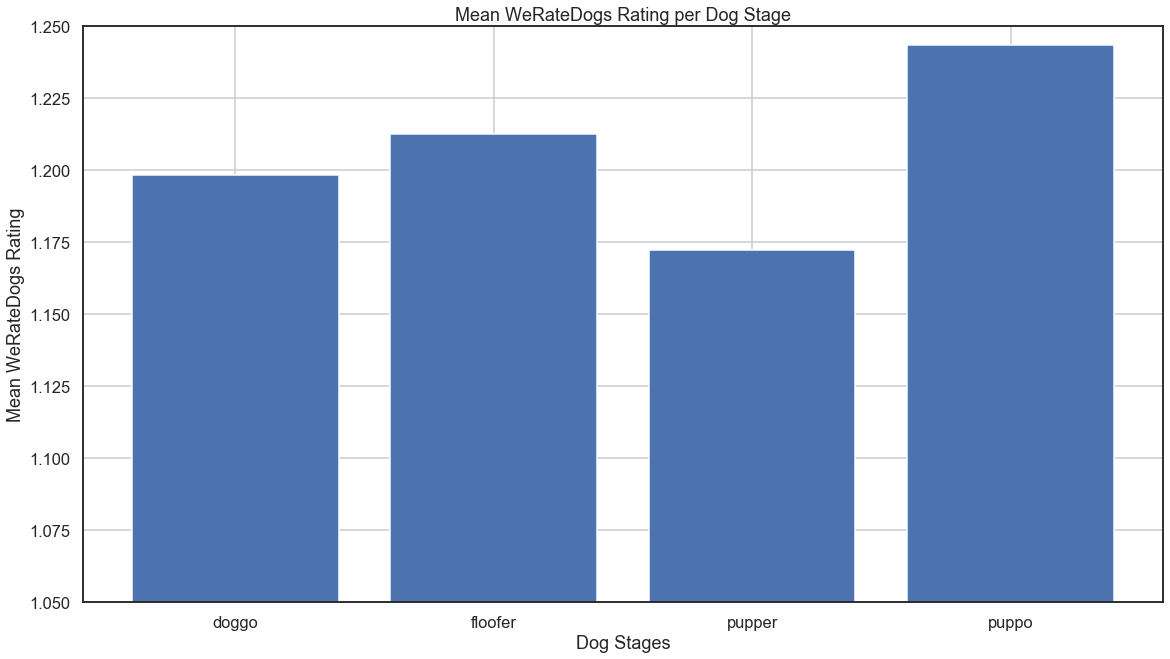

In [1730]:
# Set up the matplotlib figure
fig = plt.figure(figsize=(15,8));
ax = fig.add_axes([0,0,1,1]);
stages = ['doggo', 'floofer', 'pupper', 'puppo'];
mean_stage_rating = twitter_archive_master.groupby('stage').mean()['rating'];
ax.bar(stages,mean_stage_rating);

ax.set_ylim([1.05,1.25]);
ax.grid();
plt.xlabel('Dog Stages');
plt.ylabel('Mean WeRateDogs Rating');
plt.title('Mean WeRateDogs Rating per Dog Stage');
plt.show();

fig.savefig('A_MeanWeRateDogsRatingDogStage.png', bbox_inches='tight');


In [1731]:
mean_stage_rating

stage
doggo      1.198462
floofer    1.212500
pupper     1.172244
puppo      1.243478
Name: rating, dtype: float64

##### Mean stage rating conclusion: 
In the reviewed data the dog stage `pupppo` in mean has the highest rating with 1.210714. The stages `doggo` and `floofer`are close to that with mean ratings of 1.172222 and 1.188889. The lowest mean rating with a signifcant difference has the stage `pupper` with 1.068841.

##### B. Mean stage favorite count: 
Does the observed difference in mean rating also apply to the favorite count? Favorite count, other than rating, is a indicator of popularity among the followers of the twitter account. 

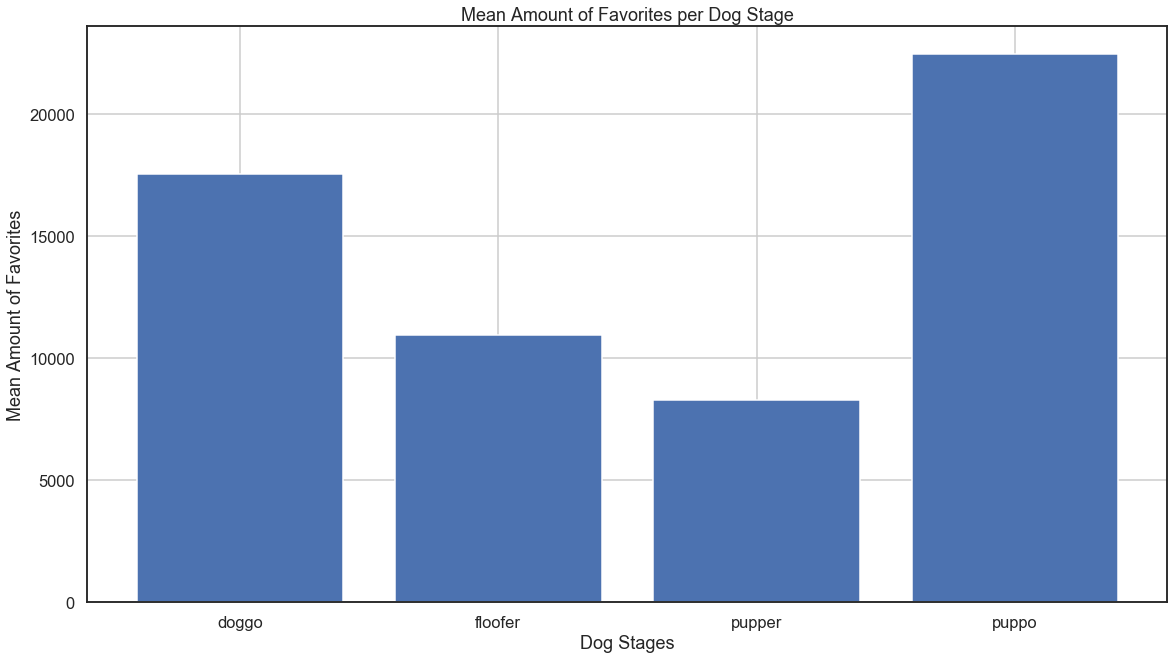

In [1732]:
# Set up the matplotlib figure
fig = plt.figure(figsize=(15,8))
ax = fig.add_axes([0,0,1,1])
stages = ['doggo', 'floofer', 'pupper', 'puppo']
mean_stage_favorite_count = twitter_archive_master.groupby('stage').mean()['favorite_count']
ax.bar(stages,mean_stage_favorite_count)
ax.grid()
plt.xlabel('Dog Stages');
plt.ylabel('Mean Amount of Favorites');
plt.title('Mean Amount of Favorites per Dog Stage');
plt.show()

fig.savefig('B_MeanAmountFavoritesDogStage.png', bbox_inches='tight')


##### Mean Stage Favorite Count Conclusion: 
As in mean stage rating as well in mean stage favorite count the stage `puppo` has higher mean values. The stage `pupper` has, like in mean stage rating, the lowest mean favorite count.

##### C. Mean Stage Retweet Count: 
Does the observed difference in mean rating and mean favorite count also apply to the retweet count? Retweet count, just like favorite count, is a indicator of popularity among the followers of the twitter account. 

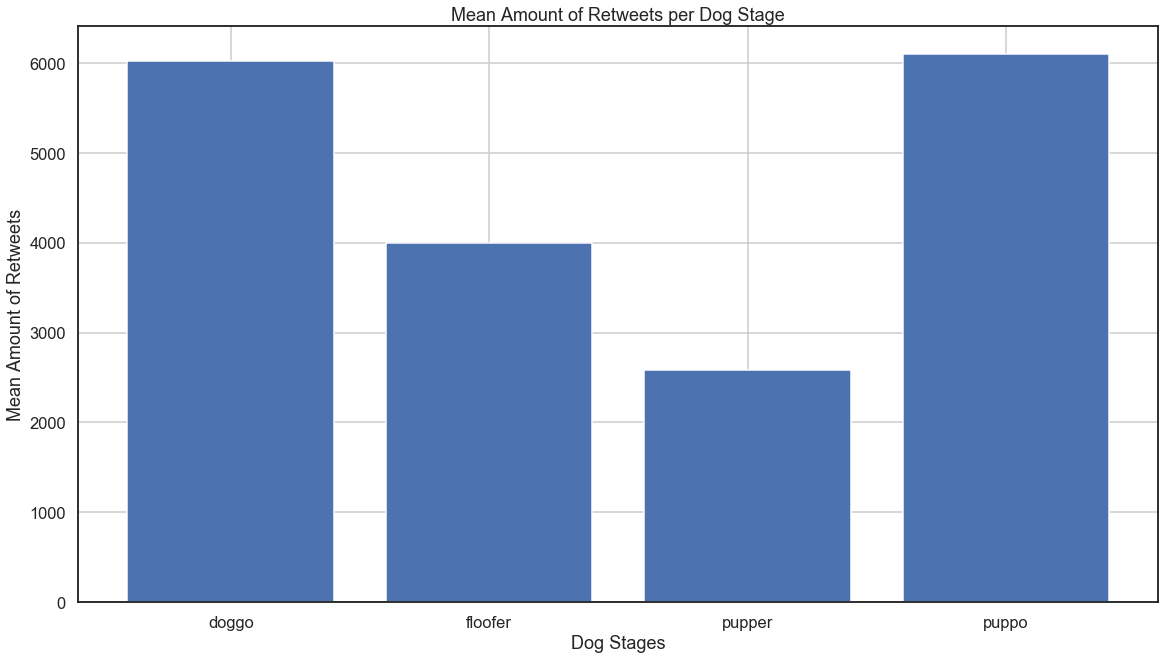

In [1733]:
# Set up the matplotlib figure
fig = plt.figure(figsize=(15,8))
ax = fig.add_axes([0,0,1,1])
stages = ['doggo', 'floofer', 'pupper', 'puppo']
mean_stage_retweet_count = twitter_archive_master.groupby('stage').mean()['retweet_count']
ax.bar(stages,mean_stage_retweet_count)
ax.grid()
plt.xlabel('Dog Stages');
plt.ylabel('Mean Amount of Retweets');
plt.title('Mean Amount of Retweets per Dog Stage');
plt.show()

fig.savefig('C_MeanAmountRetweetsDogStage.png', bbox_inches='tight')


#####  Mean Stage Retweet Count Conclusion:
In all three indicators, mean stage rating, mean stage favorite count and mean stage retweet count, the stage `puppo`performs best and the stage `pupper`performs worst.

##### D. Mean Rating Conclusion per Dog Race:
Do certain dog races get rated higher than others?

In [1734]:
# Only use observations with race prediction confidence higher than 85%
dog_races = twitter_archive_master.query('race_prediction_conf > 0.85')

In [1735]:
# Only pick races with more than 5 observations
races = dog_races.race_prediction.value_counts().index[0:10]
drop_races = dog_races.race_prediction.value_counts().index[10:]

In [1736]:
# Create mean rating per dog race
mean_race_rating = dog_races.groupby('race_prediction').mean()['rating']

# Drop races with less than 5 observations
mean_race_rating.drop(drop_races, inplace=True)

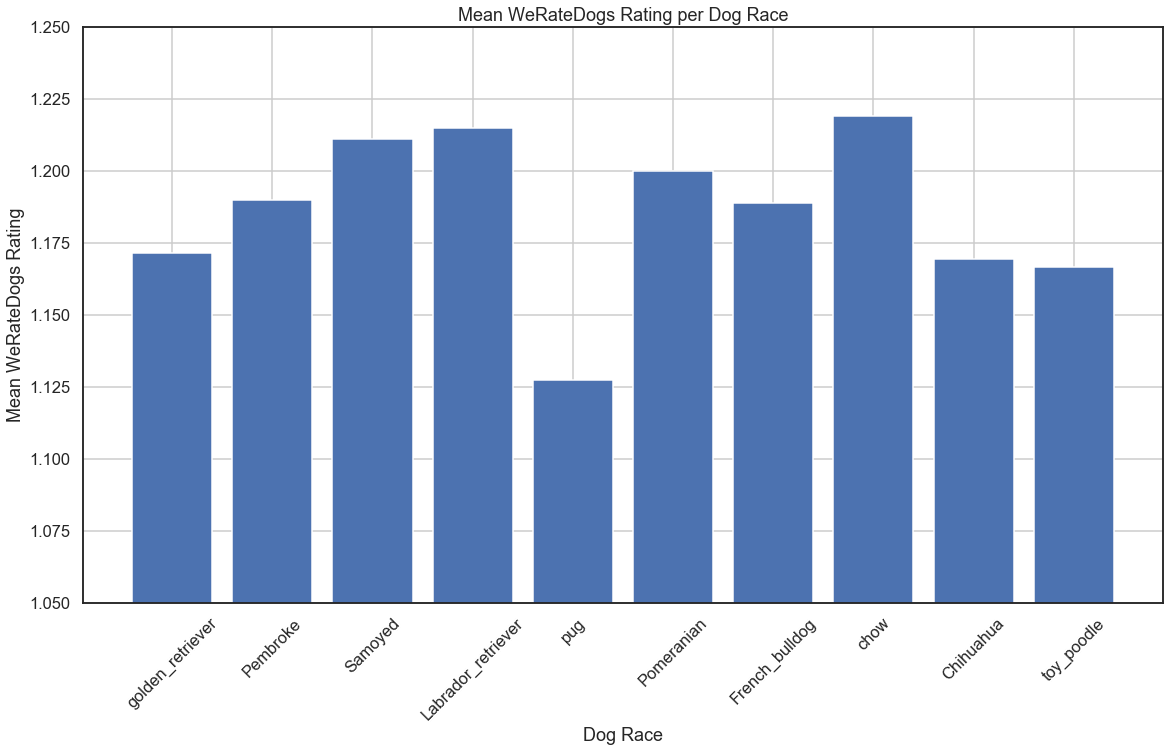

In [1737]:
# Set up the matplotlib figure
fig = plt.figure(figsize=(15,8))

ax = fig.add_axes([0,0,1,1])

ax.bar(races,mean_race_rating)
degrees = 45
plt.xticks(rotation=degrees)

ax.set_ylim([1.05,1.25])
ax.grid()
plt.xlabel('Dog Race');
plt.ylabel('Mean WeRateDogs Rating');
plt.title('Mean WeRateDogs Rating per Dog Race');
plt.show()

fig.savefig('D_MeanWeRateDogsRatingDogRace.png', bbox_inches='tight')


##### Mean Rating Conclusion per Dog Race Conclusion:
Among the dog races more than five times predicted with a certainty higher than 85%, the mean ratings of toy Labrador Retrievers, Chows and Pembrokes are the highest. Pugs, with difference, received the worst mean ratings among the analyzed data.

##### E. Mean Favorite Counts per Dog Race:
Do the same dog races, that have higher mean WeRateDog ratings, also have higher mean amounts of favorites? Hence, do the owners of the WeRateDog twitter accounte have the same preferences as the followers of the same account?

In [1738]:
# Create mean rating per dog race
mean_race_favorite_count = dog_races.groupby('race_prediction').mean()['favorite_count']

# Drop races with less than 5 observations
mean_race_favorite_count.drop(drop_races, inplace=True)

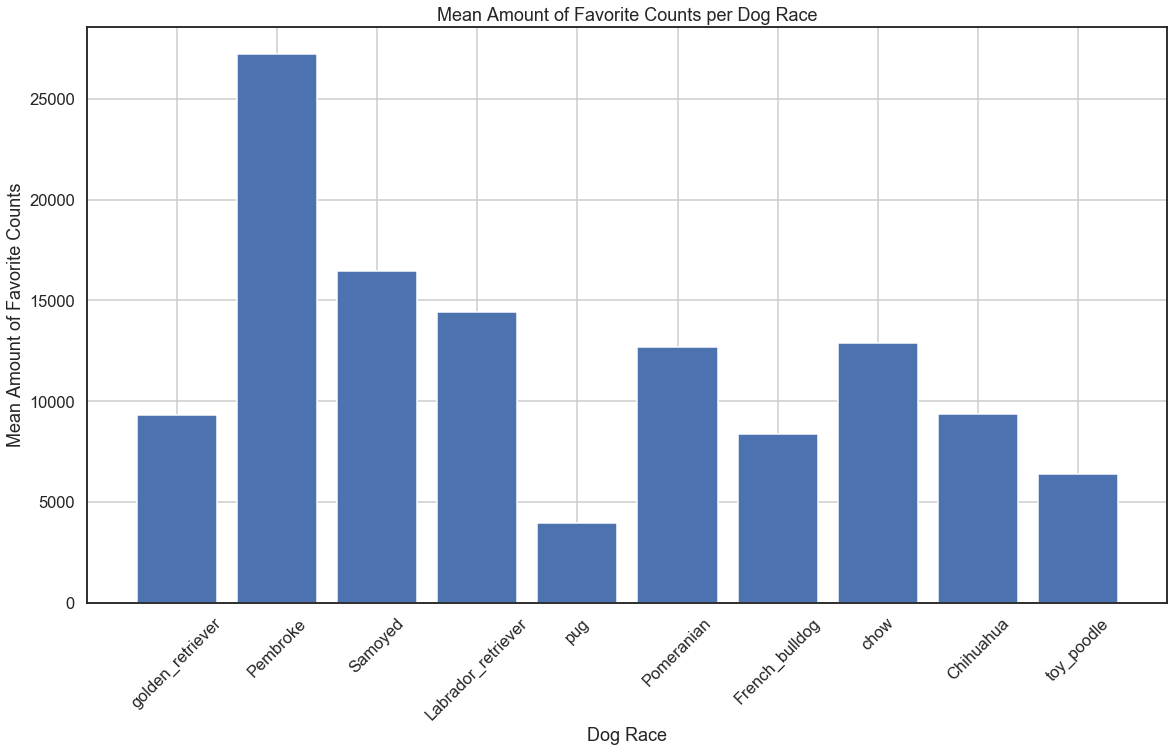

In [1739]:
# Set up the matplotlib figure
fig = plt.figure(figsize=(15,8))

ax = fig.add_axes([0,0,1,1])

ax.bar(races,mean_race_favorite_count)
degrees = 45
plt.xticks(rotation=degrees)

ax.grid()
plt.xlabel('Dog Race');
plt.ylabel('Mean Amount of Favorite Counts');
plt.title('Mean Amount of Favorite Counts per Dog Race');
plt.show()

fig.savefig('E_MeanAmountFavoriteCountsDogRace.png', bbox_inches='tight')


##### Mean Favorite Counts per Dog Race Conclusion:
The mean amount of favorite counts per race show a complete different picture than the mean dog rating per race. The mean amount of favorite counts for dogs of Pembroke race are significantly higher than the rest of races. The mean amount of favorite counts for dogs of race pug are significantly lower than for other dog races.

##### F. Mean Amount of Retweet Counts per Dog Race:
Is the ranking of dog races by mean amount of retweet counts consistent to the ranking by mean amiunt of favorite counts? As both indicators are influenced by the followers of the WeRateDog account the distribution is expected to be similar.

In [1740]:
# Create mean rating per dog race
mean_race_retweet_count = dog_races.groupby('race_prediction').mean()['retweet_count']

# Drop races with less than 5 observations
mean_race_retweet_count.drop(drop_races, inplace=True)

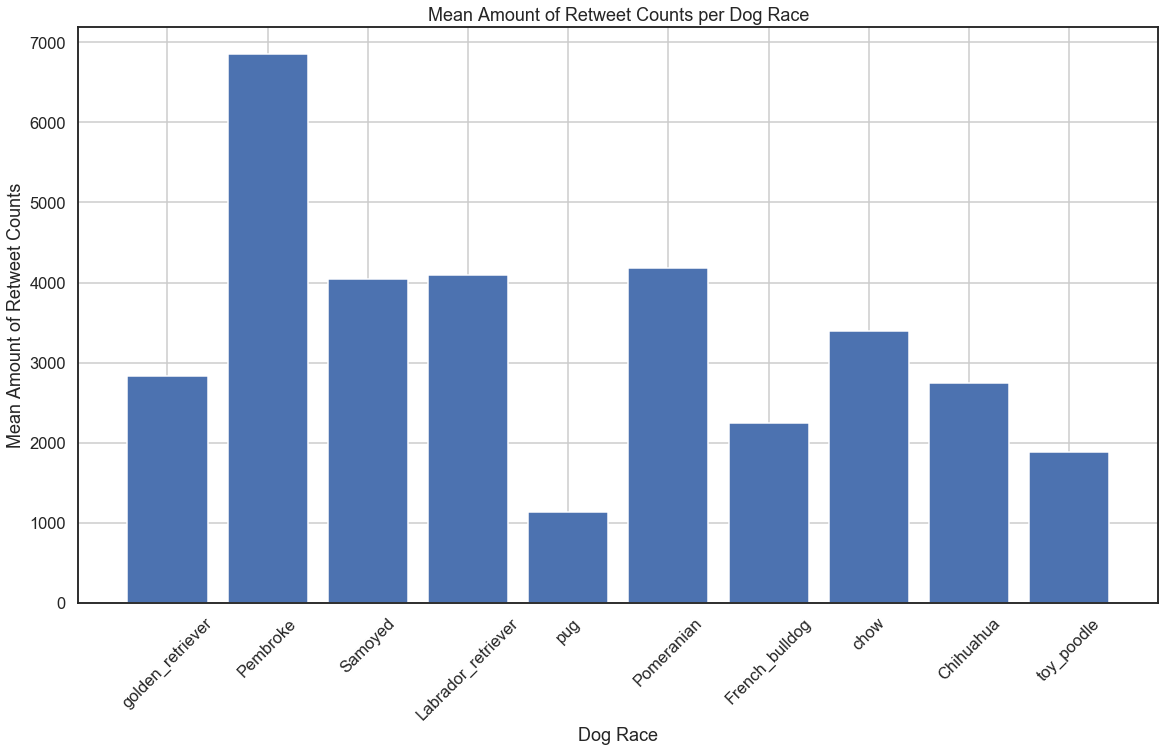

In [1741]:
# Set up the matplotlib figure
fig = plt.figure(figsize=(15,8))

ax = fig.add_axes([0,0,1,1])

ax.bar(races,mean_race_retweet_count)
degrees = 45
plt.xticks(rotation=degrees)

ax.grid()
plt.xlabel('Dog Race');
plt.ylabel('Mean Amount of Retweet Counts');
plt.title('Mean Amount of Retweet Counts per Dog Race');
plt.show()

fig.savefig('F_MeanAmountRetweetCountsDogRace.png', bbox_inches='tight')   # save the figure to file


##### Mean Amount of Retweet Counts per Dog Race Conclusion:
There is no significant difference in the ranking by mean amount of retweets and mean amount of favorites per race. The followers of the WeRateDog account behave consistently in retweeting and clicking favorite of WeRateDogs tweets.

##### G. Most Common Dog Names Among Data:
What is the most common dog name among the data collected from the WeRateDog twitter account?

In [1742]:
# Create Array with 20 most common dog names
most_common_dog_names = twitter_archive_master.name.value_counts()[0:20]

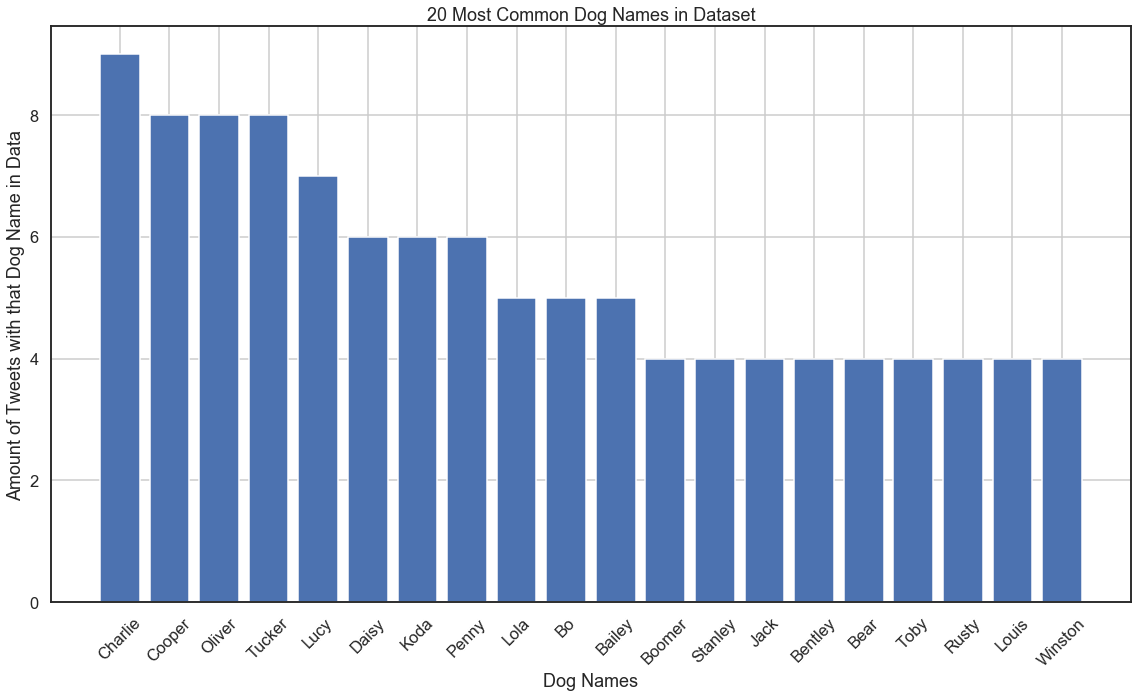

In [1744]:
# Set up the matplotlib figure
fig = plt.figure(figsize=(15,8))

ax = fig.add_axes([0,0,1,1])

ax.bar(most_common_dog_names.index,most_common_dog_names)
degrees = 45
plt.xticks(rotation=degrees)

ax.grid()
plt.xlabel('Dog Names');
plt.ylabel('Amount of Tweets with that Dog Name in Data');
plt.title('20 Most Common Dog Names in Dataset');
plt.show()

fig.savefig('G_MostCommonDogNamesDataset.jpg', bbox_inches='tight')


##### Most Common Dog Names Among Data Conclusion:
The most dog name in the dataset is Charlie.